<a href="https://colab.research.google.com/github/sadamhabnawi28/GravitationalWave_DeepLearning_project/blob/main/Example/gw_cnn_portfolio_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━

#Data Preparation

##Get Real Data

In [18]:
import os
import io
import gzip
import json
import shutil
import random
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

from pycbc.types import TimeSeries
from pycbc.filter import highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform


class GWTCDataHandler:
    def __init__(self, gwtc_csv_path, output_folder,
                 waveform_output, max_workers=8):
        """
        Full GWTC data handler: download -> extract -> process waveform.
        """
        self.gwtc_csv_path = gwtc_csv_path
        self.output_folder = output_folder
        self.waveform_output = waveform_output
        self.max_workers = max_workers

        self.gwtc_df = None
        self.json_data = []
        self.strain_metadata = []
        self.url_list = []

        os.makedirs(self.output_folder, exist_ok=True)
        os.makedirs(self.waveform_output, exist_ok=True)

    # ================================================================
    def load_gwtc_catalog(self):
        """Load the GWTC catalog CSV file."""
        print("Loading GWTC catalog...")
        self.gwtc_df = pd.read_csv(self.gwtc_csv_path)
        print(f"Loaded {len(self.gwtc_df)} catalog entries.\n")

    # ================================================================
    def fetch_json_data(self):
        """Fetch JSON data from each event URL in the catalog."""
        print("Fetching JSON metadata from URLs...")
        urls = self.gwtc_df['jsonurl'].tolist()
        for url in tqdm(urls, desc="Downloading JSON metadata", unit="file"):
            try:
                response = requests.get(url, timeout=10)
                if response.status_code == 200:
                    self.json_data.append(response.json())
                else:
                    tqdm.write(f"Failed: {url} (HTTP {response.status_code})")
            except requests.RequestException as e:
                tqdm.write(f"Error fetching {url}: {e}")
        tqdm.write(f"Total JSON files fetched: {len(self.json_data)}\n")

    # ================================================================
    def extract_strain_metadata(self):
        """Extract strain metadata for H1 or L1 detectors."""
        print("Extracting strain metadata...")
        strain_data = []
        for event_data in tqdm(self.json_data, desc="Processing JSON files", unit="file"):
            for event_name, event_info in event_data['events'].items():
                for strain in event_info['strain']:
                    if (strain['detector'] in ['H1', 'L1'] and
                        strain['sampling_rate'] == 4096 and
                        strain['duration'] == 32 and
                        strain['format'] == 'txt'):
                        strain_data.append({
                            'name': event_name,
                            'detector': strain['detector'],
                            'url': strain['url']
                        })
        self.strain_metadata = strain_data
        tqdm.write(f"Extracted {len(strain_data)} valid strain entries.\n")

    # ================================================================
    def generate_url_list(self):
        """Generate list of URLs with detector and event name."""
        print("Building URL list...")
        df_meta = pd.DataFrame(self.strain_metadata)
        df_merged = df_meta.merge(self.gwtc_df[['commonName', 'jsonurl']],
                                  left_on='name', right_on='jsonurl', how='left')
        df_merged['commonName'] = df_merged['commonName'].fillna(df_merged['name'])

        self.url_list = list(zip(df_merged['commonName'], df_merged['detector'], df_merged['url']))
        tqdm.write(f"URL list built with {len(self.url_list)} entries.\n")
        return df_merged[['commonName', 'detector', 'url']]

    # ================================================================
    def _download_and_extract_single(self, url_info):
        """Download and extract a single strain file."""
        common_name, detector, url = url_info
        file_name = f"{detector}_{common_name}.txt"
        save_path = os.path.join(self.output_folder, file_name)

        if os.path.exists(save_path):  # Skip if already exists
            return f"Skipped (exists): {file_name}"

        try:
            response = requests.get(url, stream=True, timeout=30)
            if response.status_code == 200:
                compressed_stream = io.BytesIO(response.content)
                with gzip.open(compressed_stream, 'rb') as f_in, open(save_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                return f"Saved: {file_name}"
            else:
                return f"Failed ({response.status_code}): {file_name}"
        except requests.RequestException as e:
            return f"Error {file_name}: {e}"

    # ================================================================
    def download_and_extract_parallel(self):
        """Download and extract all strain data."""
        total_files = len(self.url_list)
        print(f"Downloading and extracting {total_files} strain files...\n")

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [executor.submit(self._download_and_extract_single, info)
                       for info in self.url_list]
            with tqdm(total=total_files, desc="Extracting strain files", unit="file") as pbar:
                for future in as_completed(futures):
                    _ = future.result()
                    pbar.update(1)

        tqdm.write("All strain data downloaded and extracted!\n")

    # ================================================================
    def _get_waveform(self, strain, start_time, sample_rate, merge_time):
        """Whiten and filter the strain waveform."""
        strain = TimeSeries(strain, delta_t=1/sample_rate, epoch=start_time)
        strain = highpass(strain, 30)
        strain = strain.crop(2, 2)
        psd = strain.psd(4)
        psd = interpolate(psd, strain.delta_f)
        psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate), low_frequency_cutoff=30)
        white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
        white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
        return white_data.time_slice(merge_time - 0.8, merge_time + 0.2)

    # ================================================================
    def process_waveforms(self):
        """Process and whiten all downloaded strain files."""
        print("Processing downloaded gravitational wave data...\n")
        df = self.gwtc_df
        rand_merge = random.choice([-0.05, 0, 0.1, 0.2, 0.3, 0.4])
        count = 0

        data_files = [f for f in os.listdir(self.output_folder) if f.endswith(".txt")]

        for filename in tqdm(data_files, desc="Generating whitened waveforms", unit="file"):
            filepath = os.path.join(self.output_folder, filename)
            det, common_name = filename.split("_", 1)
            common_name = common_name.replace(".txt", "")

            # Match row in DataFrame
            try:
                row = df[(df["id"] == common_name) & (df["detector"] == det)].iloc[0]
            except IndexError:
                tqdm.write(f"No metadata found for {filename}")
                continue

            strain = np.loadtxt(filepath)
            mass1, mass2, distance = row["mass_1_source"], row["mass_2_source"], row["luminosity_distance"]
            start_time, gps_time = row["start_GPS"], row["GPS"]

            hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                                    mass1=mass1, mass2=mass2, distance=distance,
                                    delta_t=1/4096, f_lower=30)
            waveform = self._get_waveform(strain, start_time, 4096, gps_time + rand_merge)
            outname = f"waveform_mass1_{mass1:.1f}_mass2_{mass2:.1f}_distance_{distance:.1f}_{det}_{common_name}.txt"
            outpath = os.path.join(self.waveform_output, outname)
            np.savetxt(outpath, waveform, header="Real Data")
            count += 1

        tqdm.write(f"{count} gravitational wave real data waveforms processed and saved.")
        tqdm.write("DONE\n")

    # ================================================================
    def run_pipeline(self):
        """Run the full GWTC data pipeline: download → extract → process."""
        print("Starting GWTC data pipeline...\n")
        self.load_gwtc_catalog()
        self.fetch_json_data()
        self.extract_strain_metadata()
        self.generate_url_list()
        self.download_and_extract_parallel()
        self.process_waveforms()
        print("Pipeline completed successfully!")





In [19]:
gwtc_handler = GWTCDataHandler(
    gwtc_csv_path="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GWTC_123.csv",
    output_folder="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/gravitational_wave_real_data",
    waveform_output="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/gravitational_wave_real_data/waveform",
    max_workers=10
)

gwtc_handler.run_pipeline()


Starting GWTC data pipeline...

Loading GWTC catalog...
Loaded 72 catalog entries.

Fetching JSON metadata from URLs...


Total JSON files fetched: 72

Extracting strain metadata...


Processing JSON files: 100%|██████████| 72/72 [00:00<00:00, 33843.99file/s]


Extracted 134 valid strain entries.

Building URL list...
URL list built with 134 entries.




Extracting strain files: 100%|██████████| 134/134 [00:03<00:00, 34.58file/s]


All strain data downloaded and extracted!

Processing downloaded gravitational wave data...



Generating whitened waveforms: 100%|██████████| 67/67 [00:38<00:00,  1.72file/s]

67 gravitational wave real data waveforms processed and saved.
DONE

Pipeline completed successfully!


##Generate the Simulated Waveform Data

In [9]:
import os
import numpy as np
from tqdm import tqdm
from pycbc.noise.reproduceable import colored_noise
from pycbc.types import TimeSeries
from pycbc.psd import (
    aLIGOZeroDetHighPower, aLIGOZeroDetLowPower, aLIGOaLIGO175MpcT1800545,
    aLIGOThermal, AdvVirgo, AdVO3LowT1800545, AdVEarlyLowSensitivityP1200087,
    AdVEarlyHighSensitivityP1200087, AdVBNSOptimizedSensitivityP1200087,
    AdVDesignSensitivityP1200087
)

class L1NoiseGenerator:
    def __init__(self, data_folder="gravitational_wave_real_data", output_folder="generated_noises"):
        self.data_folder = data_folder
        self.output_folder = output_folder
        os.makedirs(self.output_folder, exist_ok=True)

    def _generate_noise(self, input_filename, psd_func):
        """Generate a single noise sample for an event file."""
        # Extract event ID (e.g. 'GW151012') from filename
        event_id = os.path.splitext(input_filename)[0].split('_')[1]
        save_name = f"L1_{event_id}_noise.txt"
        save_path = os.path.join(self.output_folder, save_name)

        strain_data = np.loadtxt(os.path.join(self.data_folder, input_filename), skiprows=3)
        strain = TimeSeries(strain_data, 1/4096)
        delta_f = strain.delta_f
        psd = psd_func(delta_f)

        noise = colored_noise(psd, 0, 32, seed=123, sample_rate=4096)
        np.savetxt(save_path, noise, header=f"Noise sample for {event_id}")
        return save_path

    def generate_all_noises(self, overwrite=False):
        """Generate 4 L1 noise files with tqdm progress bar."""
        configs = [
            ("L1_GW151012-v3.txt", self.psd_15),
            ("L1_GW170809-v1.txt", self.psd_17),
            ("L1_GW190517_055101-v1.txt", self.psd_19),
            ("L1_GW200225_060421-v1.txt", self.psd_20)
        ]

        generated_files = []
        for filename, psd_func in tqdm(configs, desc="Generating L1 noise samples", unit="file"):
            event_id = os.path.splitext(filename)[0].split('_')[1]
            save_path = os.path.join(self.output_folder, f"L1_{event_id}_noise.txt")
            if not os.path.exists(save_path) or overwrite:
                generated_files.append(self._generate_noise(filename, psd_func))
            else:
                generated_files.append(save_path)
        return generated_files

    # ===== PSD generator functions for each noise =====
    def psd_15(self, delta_f):
        psd = AdVBNSOptimizedSensitivityP1200087(32*4096, delta_f, 15)/43
        psd += aLIGOZeroDetHighPower(32*4096, delta_f, 15)*5
        psd += AdVO3LowT1800545(32*4096, delta_f, 15)/20
        psd += aLIGOaLIGO175MpcT1800545(32*4096, delta_f, 15)/200
        psd += aLIGOThermal(32*4096, delta_f, 15)/80
        psd += AdvVirgo(32*4096, delta_f, 15)/700
        psd += AdVDesignSensitivityP1200087(32*4096, delta_f, 15)/1000
        psd += AdVEarlyHighSensitivityP1200087(32*4096, delta_f, 15)/5e3
        psd += AdVEarlyLowSensitivityP1200087(32*4096, delta_f, 15)/37.5
        return psd

    def psd_17(self, delta_f):
        psd = AdVBNSOptimizedSensitivityP1200087(32*4096, delta_f, 15)/10.5
        psd += aLIGOZeroDetLowPower(32*4096, delta_f, 15)
        psd += AdVDesignSensitivityP1200087(32*4096, delta_f, 15)/6.22
        psd += AdVEarlyHighSensitivityP1200087(32*4096, delta_f, 15)/450
        psd += AdVEarlyLowSensitivityP1200087(32*4096, delta_f, 15)/600
        return psd

    def psd_19(self, delta_f):
        psd = aLIGOaLIGO175MpcT1800545(32*4096, delta_f, 15)
        psd += AdVBNSOptimizedSensitivityP1200087(32*4096, delta_f, 15)/800
        psd += aLIGOZeroDetHighPower(32*4096, delta_f, 15)/1.51
        psd += AdVO3LowT1800545(32*4096, delta_f, 15)/100
        psd += aLIGOThermal(32*4096, delta_f, 15)/1000
        psd += AdvVirgo(32*4096, delta_f, 15)/1000
        return psd

    def psd_20(self, delta_f):
        psd = AdVBNSOptimizedSensitivityP1200087(32*4096, delta_f, 15)/50
        psd += AdVO3LowT1800545(32*4096, delta_f, 15)/40
        psd += aLIGOaLIGO175MpcT1800545(32*4096, delta_f, 15)/65
        psd += AdVDesignSensitivityP1200087(32*4096, delta_f, 15)/1.319
        return psd



# ==========================================================
# CLASS 2: GWTC Waveform Simulator
# ==========================================================
class GWTCWaveformSimulator:
    def __init__(self, noise_folder, output_folder):
        self.noise_folder = noise_folder
        self.output_folder = output_folder
        self.sample_rate = 4096
        self.f_lower = 30
        self.total_duration = 32
        self.start_time = 0
        os.makedirs(self.output_folder, exist_ok=True)

        # Load noise files
        self.noise_files = [np.loadtxt(os.path.join(noise_folder, f"L1_{n}_noise.txt"), skiprows=1)
                            for n in ["GW151012-v3", "GW170809-v1",
                                      "GW190517", "GW200225"]]

    def add_noise(self, hp):
        """Insert waveform into random noise background."""
        total_samples = self.total_duration * self.sample_rate
        waveform_data = np.zeros(total_samples)
        waveform_data[15*self.sample_rate:15*self.sample_rate+len(hp)] = hp.data
        waveform_data += random.choice(self.noise_files)
        return waveform_data

    def get_waveform(self, strain, merge_time):
        """Whiten and filter waveform data."""
        strain = TimeSeries(strain, delta_t=1/self.sample_rate, epoch=self.start_time)
        strain = highpass(strain, 30).crop(2, 2)
        psd = interpolate(strain.psd(4), strain.delta_f)
        psd = inverse_spectrum_truncation(psd, int(4*strain.sample_rate), low_frequency_cutoff=self.f_lower)
        white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
        white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
        return white_data.time_slice(merge_time-0.8, merge_time+0.2)

    def run_simulations(self, mass_range, distance_range):
        """Run all waveform simulations with tqdm progress bars."""
        sim_count = 0
        total_jobs = sum(1 for m1 in mass_range for m2 in mass_range if m2 >= m1 for _ in distance_range)

        with tqdm(total=total_jobs, desc="Generating waveforms", unit="sim") as pbar:
            for mass1 in mass_range:
                for mass2 in mass_range:
                    if mass2 >= mass1:
                        for distance in distance_range:
                            hp, _ = get_td_waveform(
                                approximant="SEOBNRv4_opt",
                                mass1=mass1, mass2=mass2, distance=distance,
                                delta_t=1/self.sample_rate, f_lower=self.f_lower
                            )

                            noisy_strain = self.add_noise(hp)
                            merge_time = 15 + len(hp)/self.sample_rate
                            processed_wave = self.get_waveform(noisy_strain, merge_time)

                            filename = f"waveform_m1_{mass1:.1f}_m2_{mass2:.1f}_d_{distance:.1f}.txt"
                            np.savetxt(os.path.join(self.output_folder, filename), processed_wave, header="Noisy Strain h+")
                            sim_count += 1
                            pbar.update(1)

        tqdm.write(f"{sim_count} gravitational wave simulations completed and saved.")


In [10]:
#from gwtc_waveform_pipeline import L1NoiseGenerator, GWTCWaveformSimulator
import numpy as np

# STEP 1: Generate noise samples (only needed once)
noise_gen = L1NoiseGenerator(
    data_folder="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/gravitational_wave_real_data",
    output_folder="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/generated_noises")
generated = noise_gen.generate_all_noises()
print(generated)


# STEP 2: Run waveform simulations
sim = GWTCWaveformSimulator(
    noise_folder="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/generated_noises",
    output_folder="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data")
mass_range = np.linspace(5, 45, 8)
distance_range = np.linspace(600, 1945, 4)
sim.run_simulations(mass_range, distance_range)


Generating L1 noise samples: 100%|██████████| 4/4 [00:00<00:00, 2725.34file/s]


['/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/generated_noises/L1_GW151012-v3_noise.txt', '/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/generated_noises/L1_GW170809-v1_noise.txt', '/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/generated_noises/L1_GW190517_noise.txt', '/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/generated_noises/L1_GW200225_noise.txt']


Generating waveforms: 100%|██████████| 144/144 [01:07<00:00,  2.13sim/s]

144 gravitational wave simulations completed and saved.


##Load and transform the waveforms into spectrograms

In [11]:
import os
import numpy as np
from tqdm import tqdm
from scipy import signal
import tensorflow as tf


class WaveformDatasetLoader:
    def __init__(self, data_dir, output_subdir="training_data"):
        """
        Handles loading, saving, and converting waveform simulation data.

        Args:
            data_dir (str): Directory containing waveform .txt files.
            output_subdir (str): Folder inside data_dir to store saved numpy arrays.
        """
        self.data_dir = data_dir
        self.output_dir = os.path.join(data_dir, output_subdir)
        os.makedirs(self.output_dir, exist_ok=True)
        self.X = None
        self.y = None
        self.spectrograms = None
        self.labels = None

    # ------------------------------------------------------------------
    def _parse_filename(self, filename):
        """
        Extracts mass1, mass2, and distance values from a standardized filename.
        Expected format: waveform_mass1_<m1>_mass2_<m2>_distance_<dist>_<det>_<event>.txt
        """
        parts = filename.split('_')
        try:
            mass1 = float(parts[2])
            mass2 = float(parts[4])
            distance = float(parts[6].replace(".txt", ""))
            return mass1, mass2, distance
        except (IndexError, ValueError):
            raise ValueError(f"Filename '{filename}' does not follow expected format.")

    # ------------------------------------------------------------------
    def load_data(self):
        """Load waveform .txt files into numpy arrays (time series)."""
        X, y = [], []
        txt_files = [f for f in os.listdir(self.data_dir) if f.endswith(".txt")]

        for filename in tqdm(txt_files, desc="Loading waveform data", unit="file"):
            filepath = os.path.join(self.data_dir, filename)
            try:
                mass1, mass2, distance = self._parse_filename(filename)
                strain = np.loadtxt(filepath, skiprows=1)
                X.append(strain)
                y.append([mass1, mass2, distance])
            except Exception as e:
                tqdm.write(f"Skipping {filename}: {e}")

        self.X = np.array(X, dtype=float)
        self.y = np.array(y, dtype=float)
        tqdm.write(f"Loaded {len(self.X)} waveform samples.\n")
        return self.X, self.y

    # ------------------------------------------------------------------
    def save_arrays(self):
        """Save X and y arrays to the output directory."""
        if self.X is None or self.y is None:
            raise RuntimeError("Data not loaded yet. Run load_data() first.")
        X_path = os.path.join(self.output_dir, "X_sim.txt")
        y_path = os.path.join(self.output_dir, "y_sim.txt")
        np.savetxt(X_path, self.X, delimiter=",")
        np.savetxt(y_path, self.y, delimiter=",")
        tqdm.write(f"Saved arrays to:\n- {X_path}\n- {y_path}")

    # ------------------------------------------------------------------
    def convert_to_spectrograms(self, resize_shape=(128, 128), fs=4096):
        """
        Convert loaded waveform time-series data into 2D spectrograms.

        Args:
            resize_shape (tuple): Desired spectrogram image size (H, W).
            fs (int): Sampling rate in Hz.

        Returns:
            tuple: (spectrograms, labels)
        """
        if self.X is None or self.y is None:
            raise RuntimeError("Data not loaded yet. Run load_data() first.")

        spectrograms = []
        labels = []

        for i in tqdm(range(len(self.X)), desc="Converting to spectrograms", unit="waveform"):
            strain = self.X[i]
            label = self.y[i]

            freq, times, spec = signal.spectrogram(
                strain,
                fs=fs,
                nperseg=512,
                noverlap=256
            )

            # Normalize and crop
            spec /= spec.max() + 1e-12
            freq_mask = freq <= 512
            spec_cropped = spec[freq_mask, :]

            # Expand and resize
            spec_cropped = np.expand_dims(spec_cropped, axis=-1)
            spec_resized = tf.image.resize(spec_cropped, size=resize_shape).numpy()

            spectrograms.append(spec_resized)
            labels.append(label)

        self.spectrograms = np.array(spectrograms, dtype=np.float32)
        self.labels = np.array(labels, dtype=np.float32)

        tqdm.write(f"Generated {len(self.spectrograms)} spectrograms ({resize_shape[0]}×{resize_shape[1]}).")
        return self.spectrograms, self.labels

    # ------------------------------------------------------------------
    def save_spectrograms(self):
        """Save spectrograms and labels as .npy files."""
        if self.spectrograms is None or self.labels is None:
            raise RuntimeError("Spectrograms not generated yet. Run convert_to_spectrograms() first.")

        X_path = os.path.join(self.output_dir, "X_spectrograms.npy")
        y_path = os.path.join(self.output_dir, "y_labels.npy")
        np.save(X_path, self.spectrograms)
        np.save(y_path, self.labels)
        tqdm.write(f"Saved spectrogram data:\n- {X_path}\n- {y_path}")

    # ------------------------------------------------------------------
    def run_pipeline(self):
        """Full pipeline: load -> convert -> save."""
        tqdm.write("Running full waveform-to-spectrogram pipeline...\n")
        self.load_data()
        self.convert_to_spectrograms()
        self.save_spectrograms()
        tqdm.write("Pipeline complete!\n")


# Create and run pipeline
loader = WaveformDatasetLoader(data_dir="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data")

# Run the full preprocessing pipeline
loader.run_pipeline()

# Access spectrograms and labels
X_specs, y_labels = loader.spectrograms, loader.labels
print("Spectrograms shape:", X_specs.shape)
print("Labels shape:", y_labels.shape)


Running full waveform-to-spectrogram pipeline...



Loading waveform data: 100%|██████████| 103/103 [00:00<00:00, 147.15file/s]


Loaded 103 waveform samples.



Converting to spectrograms: 100%|██████████| 103/103 [00:01<00:00, 85.60waveform/s]

Generated 103 spectrograms (128×128).
Saved spectrogram data:
- /content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/training_data/X_spectrograms.npy
- /content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/training_data/y_labels.npy
Pipeline complete!

Spectrograms shape: (103, 128, 128, 1)
Labels shape: (103, 3)


In [12]:
# Create and run pipeline
loader = WaveformDatasetLoader(data_dir="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/gravitational_wave_real_data/waveform")

# Run the full preprocessing pipeline
loader.run_pipeline()

# Access spectrograms and labels
X_specs, y_labels = loader.spectrograms, loader.labels
print("Spectrograms shape:", X_specs.shape)
print("Labels shape:", y_labels.shape)

Running full waveform-to-spectrogram pipeline...



Loading waveform data: 0file [00:00, ?file/s]


Loaded 0 waveform samples.



Converting to spectrograms: 0waveform [00:00, ?waveform/s]

Generated 0 spectrograms (128×128).
Saved spectrogram data:
- /content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/gravitational_wave_real_data/waveform/training_data/X_spectrograms.npy
- /content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/gravitational_wave_real_data/waveform/training_data/y_labels.npy
Pipeline complete!

Spectrograms shape: (0,)
Labels shape: (0,)


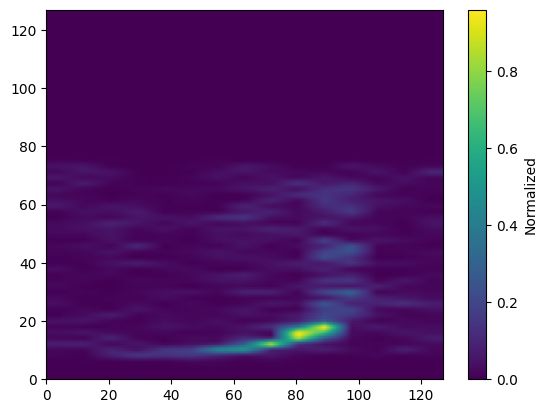

In [13]:
import matplotlib.pyplot as plt

spec = np.load("/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/training_data/X_spectrograms.npy")

plt.pcolormesh(spec[23][:,:,0], shading='gouraud')
plt.colorbar(label='Normalized')
plt.show()

#Data Training

In [20]:
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, backend as K
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tqdm import tqdm


class SpectrogramCNNTrainer:
    def __init__(self,
                 sim_data_dir,
                 real_data_dir,
                 model_output_dir,
                 test_size=0.2,
                 random_state=42):
        """
        Handles loading, normalizing, training, and saving a CNN for spectrogram data.

        Args:
            sim_data_dir (str): Path to folder containing simulation spectrogram .npy/.txt files.
            real_data_dir (str): Path to folder containing real spectrogram .npy/.txt files.
            model_output_dir (str): Directory to save trained model and history.
            test_size (float): Fraction for test data split.
            random_state (int): Random seed for reproducibility.
        """
        self.sim_data_dir = sim_data_dir
        self.real_data_dir = real_data_dir
        self.model_output_dir = model_output_dir
        self.test_size = test_size
        self.random_state = random_state
        os.makedirs(model_output_dir, exist_ok=True)

        self.X_sim, self.y_sim = None, None
        self.X_real, self.y_real = None, None
        self.model = None
        self.history = None

    # ----------------------------------------------------------
    def load_data(self):
        """Load simulated and real spectrogram data."""
        tqdm.write("Loading spectrogram datasets...")

        self.X_sim = np.load(os.path.join(self.sim_data_dir, "X_spectrograms.npy"))
        self.y_sim = np.load(os.path.join(self.sim_data_dir, "y_labels.npy"))

        self.X_real = np.load(os.path.join(self.real_data_dir, "X_spectrograms.npy"))
        self.y_real = np.load(os.path.join(self.real_data_dir, "y_labels.npy"))

        tqdm.write(f"Loaded simulation data: {self.X_sim.shape}")
        tqdm.write(f"Loaded real data: {self.X_real.shape}\n")

    # ----------------------------------------------------------
    def normalize_targets(self):
        """Normalize target labels (mass1, mass2, distance) to 0–1 range per sample."""
        def normalize_y(y):
            for i in range(len(y)):
                y[i, 0] /= np.max(y[i, 0])
                y[i, 1] /= np.max(y[i, 1])
                y[i, 2] /= np.max(y[i, 2])
            return y

        tqdm.write("Normalizing y values...")
        self.y_sim = normalize_y(self.y_sim)
        self.y_real = normalize_y(self.y_real)
        tqdm.write("Normalization complete.\n")


    # ----------------------------------------------------------
    @staticmethod
    def build_cnn_model(input_shape):
        """Build a CNN model for spectrogram regression."""
        K.clear_session()
        model = Sequential([

            layers.Input(input_shape),

            layers.Conv2D(128, (6,6), padding='same', kernel_initializer='glorot_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),

            layers.Conv2D(64, (6,6), padding='same', kernel_initializer='glorot_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),

            layers.Conv2D(32, (6,6), padding='same', kernel_initializer='glorot_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2,2)),

            layers.Conv2D(64, (6,6), padding='same', kernel_initializer='glorot_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2,2)),

            layers.Conv2D(128, (6,6), padding='same', kernel_initializer='glorot_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2,2)),

            layers.Conv2D(16, (6,6), padding='same', kernel_initializer='glorot_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2,2)),

            layers.GlobalAveragePooling2D(),

            layers.Dense(128),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.3),

            layers.Dense(64),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.3),

            layers.Dense(3)
        ])
        return model

    # ----------------------------------------------------------
    def train_cnn_model(self, X_train, y_train):
        """Compile, train, and validate CNN model."""
        tqdm.write("Starting CNN training...")
        input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
        cnn_model = self.build_cnn_model(input_shape)

        cnn_model.compile(
            optimizer=optimizers.Adam(),
            loss='Huber'
        )

        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
        lr_schedule = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=15,
            min_lr=1e-12
        )

        history = cnn_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stopping, lr_schedule],
            verbose=1
        )

        tqdm.write("CNN training complete.\n")
        self.model = cnn_model
        self.history = history
        return cnn_model, history

    # ----------------------------------------------------------
    def save_model_and_history(self, model_name="model_gwcnn"):
        """Save trained model (.keras) and training history (.pkl)."""
        model_path = os.path.join(self.model_output_dir, f"{model_name}.keras")
        hist_path = os.path.join(self.model_output_dir, f"history_{model_name}.pkl")

        self.model.save(model_path)
        with open(hist_path, "wb") as f:
            pickle.dump(self.history.history, f)

        tqdm.write(f"Saved model: {model_path}")
        tqdm.write(f"Saved training history: {hist_path}")

    # ----------------------------------------------------------
    def run_pipeline(self):
        """Full pipeline: load -> normalize -> split -> train -> save."""
        tqdm.write("Starting Spectrogram CNN training pipeline...\n")

        # 1. Load data
        self.load_data()

        # 2. Normalize labels
        self.normalize_targets()

        # 3. Train-test split (only on simulated data)
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_sim, self.y_sim,
            test_size=self.test_size,
            random_state=self.random_state
        )

        # 4. Train model
        self.train_cnn_model(X_train, y_train)

        # 5. Save results
        self.save_model_and_history()

        tqdm.write("Training pipeline complete!\n")


In [21]:
trainer = SpectrogramCNNTrainer(
    sim_data_dir="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/GW_L1_sim_data/training_data",
    real_data_dir="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/gravitational_wave_real_data/waveform/training_data",
    model_output_dir="/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project"
)

trainer.run_pipeline()


Starting Spectrogram CNN training pipeline...

Loading spectrogram datasets...
Loaded simulation data: (103, 128, 128, 1)
Loaded real data: (0,)

Normalizing y values...
Normalization complete.

Starting CNN training...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 0.6530 - val_loss: 0.4941 - learning_rate: 0.0010
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.5802 - val_loss: 0.4895 - learning_rate: 0.0010
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.6044 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.5096 - val_loss: 0.4856 - learning_rate: 0.0010
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.5312 - val_loss: 0.4725 - learning_rate: 0.0010
CNN training complete.

Saved model: /content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/model_gwcnn.keras
Saved training history: /content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/history_model_gwcnn.pkl
Training pipelin

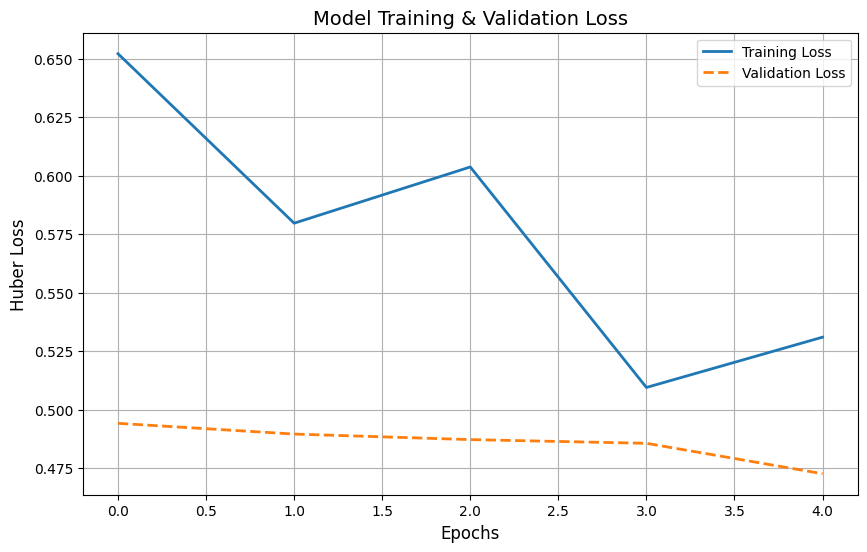

In [22]:
import pickle
import matplotlib.pyplot as plt

# === Path to your saved history file ===
history_path = "/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/history_model_gwcnn.pkl"

# === Load the training history ===
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# === Plot Training vs Validation Loss ===
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('Model Training & Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K

# === Load your saved model ===
model_path = "/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/model_gwcnn.keras"
model = load_model(model_path)

# === Print the model summary ===
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 16)     │        73,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             

 Total params: 2,485,019 (9.48 MB)

 Trainable params: 827,923 (3.16 MB)

 Non-trainable params: 1,248 (4.88 KB)

 Optimizer params: 1,655,848 (6.32 MB)

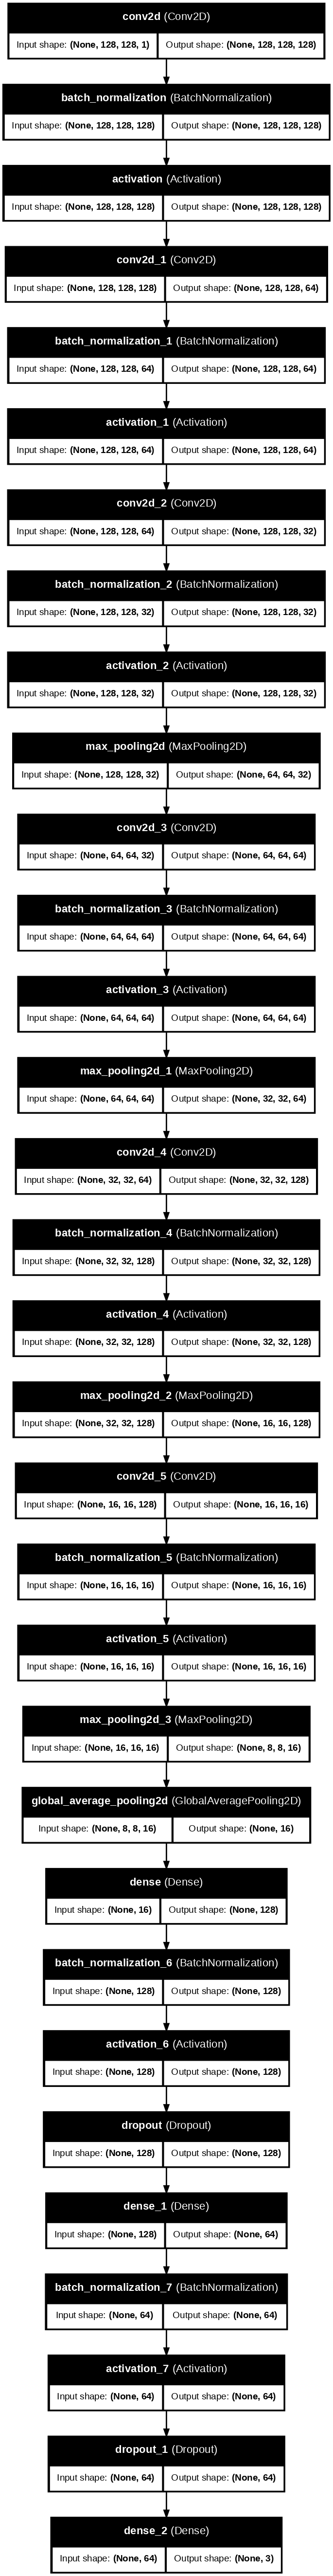

In [29]:
from tensorflow.keras.utils import plot_model

# === Save model diagram as an image ===
plot_path = "/content/drive/MyDrive/Colab Notebooks/GW_CNN_portfolio_project/model_cnn_architecture.png"

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=100
)

